<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/DL_Models/TestingTransformelModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 331 (delta 42), reused 9 (delta 9), pack-reused 268 (from 2)
Receiving objects: 100% (331/331), 25.42 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [2]:
import numpy as np
import joblib
import pandas as pd

In [3]:
!unzip -o dl_preprocessed.zip

Archive:  dl_preprocessed.zip
  inflating: dl_data_windows.npz     
  inflating: label_encoder.pkl       
  inflating: scaler.pkl              


In [4]:
# Load arrays
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]
feature_cols     = data["feature_cols"].tolist()
classes          = data["classes"]

# Load encoder & scaler
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


In [5]:
import torch

try:
    model = torch.load("best_model.pth", map_location="cpu")
    print("✅ Loaded full PyTorch model")
except Exception as e:
    print("❌ Could not load model directly:", e)
    print("⚠️ If this file only has state_dict, you’ll need the model architecture.")

✅ Loaded full PyTorch model


In [8]:
import torch
import torch.nn as nn

In [15]:
import torch
import torch.nn as nn

class TheirTransformer(nn.Module):
    def __init__(self, d_model=10, nhead=2, num_layers=2, dim_feedforward=2048, dropout=0.1):
        super(TheirTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # ✅ Match checkpoint: Linear -> ReLU -> Linear
        self.fc = nn.Sequential(
            nn.Linear(d_model, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.transformer_encoder(x)   # (batch, seq_len, d_model)
        x = x.mean(dim=1)                 # Pool across sequence
        x = self.fc(x)
        return self.sigmoid(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TheirTransformer(d_model=10, nhead=2, num_layers=2, dim_feedforward=2048).to(device)

state_dict = torch.load("best_model.pth", map_location=device)
model.load_state_dict(state_dict)   # ✅ should now work
model.eval()
print("✅ Pretrained model loaded successfully")



✅ Pretrained model loaded successfully


In [17]:
# -----------------------
# Load your splits
# -----------------------
import pandas as pd
import numpy as np
import joblib

train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [18]:
# Load arrays (these were already preprocessed)
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]
feature_cols     = data["feature_cols"].tolist()
classes          = data["classes"]

# Load encoder & scaler (if needed later)
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


In [20]:
# Find the index of the "none" class
none_idx = np.where(classes == "none")[0][0]
print("Index of 'none':", none_idx)

# Convert multi-class labels into binary (normal vs attack)
y_train_bin = (y_train != none_idx).astype(int)
y_val_bin   = (y_val   != none_idx).astype(int)
y_test_bin  = (y_test  != none_idx).astype(int)

print("Binary class distribution in test:", np.bincount(y_test_bin))


Index of 'none': 5
Binary class distribution in test: [220 370]



✅ Pretrained Model Results
Accuracy: 0.3694915254237288
F1 Score: 0.4241486068111455
              precision    recall  f1-score   support

      Normal       0.26      0.37      0.30       220
      Attack       0.50      0.37      0.42       370

    accuracy                           0.37       590
   macro avg       0.38      0.37      0.36       590
weighted avg       0.41      0.37      0.38       590



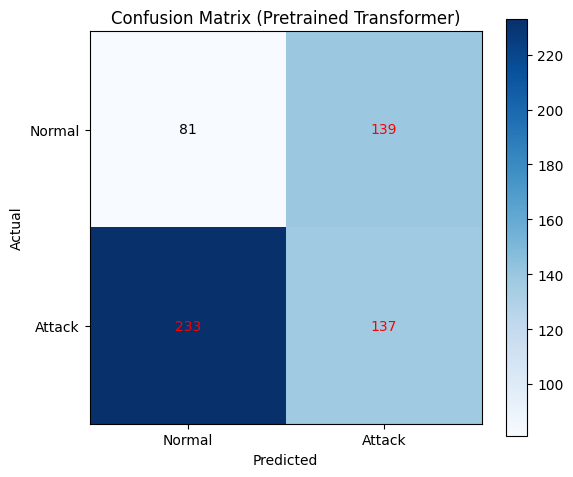

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# -----------------------
# Adapter + Wrapper
# -----------------------
class InputAdapter(nn.Module):
    def __init__(self, input_dim=222, embed_dim=10):  # pretrained model expects 10
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        # x shape: (batch, seq_len, 222)
        return self.proj(x)

class FullModel(nn.Module):
    def __init__(self, adapter, transformer_model):
        super().__init__()
        self.adapter = adapter
        self.transformer = transformer_model

    def forward(self, x):
        x = self.adapter(x)        # project to 10 dims
        return self.transformer(x) # forward through pretrained

# Initialize adapter + wrap pretrained model
adapter = InputAdapter(input_dim=X_test.shape[2], embed_dim=10).to(device)
full_model = FullModel(adapter, model).to(device)
full_model.eval()

# -----------------------
# Convert numpy arrays -> PyTorch tensors
# -----------------------
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_bin, dtype=torch.float32).to(device)  # binary labels

# Create DataLoader for test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -----------------------
# Evaluation
# -----------------------
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = full_model(X_batch)  # use wrapper instead of model
        preds = (outputs > 0.5).long().cpu().numpy()  # threshold 0.5
        all_preds.extend(preds.flatten())
        all_labels.extend(y_batch.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -----------------------
# Metrics
# -----------------------
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Normal", "Attack"])
cm = confusion_matrix(all_labels, all_preds)

print("\n✅ Pretrained Model Results")
print("Accuracy:", acc)
print("F1 Score:", f1)
print(report)

# -----------------------
# Confusion Matrix Plot
# -----------------------
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Pretrained Transformer)")
plt.colorbar()
plt.xticks([0,1], ["Normal","Attack"])
plt.yticks([0,1], ["Normal","Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Add counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="red" if cm[i,j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()
